# Machine Learning Capstone Project

## Credit Card Fraud Detection

In this project, I will be designing multiple models to detect fraud transactions from a given set of transactions.

I have implemented 3 algorithms: Logistic Regression, Random Forest, Autoencoder

In [1]:
# importing the required packages

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import utils

Using TensorFlow backend.


In [2]:
%matplotlib inline

RANDOM_SEED = 45
LABELS = ["Normal", "Fraud"]

Let's import the dataset and have a look at the data.

In [3]:
df = pd.read_csv("data/creditcard.csv")
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#check for missing values
df.isnull().values.any()

False

### Data Visualization

Let's visualize the distribution of transactions into fraud and genuine class.

Text(0.5, 1.0, 'Transaction class distribution')

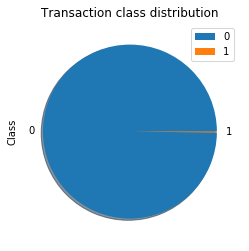

In [5]:
# Class wise(Normal & Fraud) distribution of data
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'pie', shadow=True, legend=True)
plt.title("Transaction class distribution")

In [6]:
# Dividing the dataset into fraud and genuine transactions
frauds = df[df.Class == 1]
genuine = df[df.Class == 0]

print(frauds.shape, genuine.shape)

(492, 31) (284315, 31)


Distribution of transactions with amount involved in them

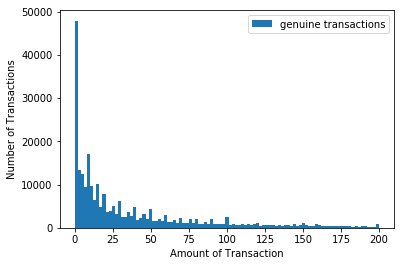

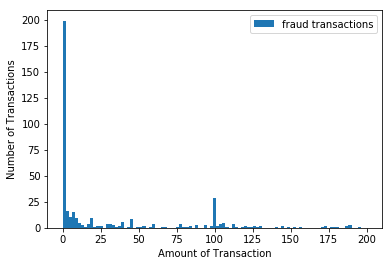

In [7]:
bins = np.linspace(0, 200, 100)

plt.hist(genuine.Amount, bins, label='genuine transactions')
plt.legend(loc='upper right')
plt.xlabel('Amount of Transaction')
plt.ylabel('Number of Transactions')
plt.show()

plt.hist(frauds.Amount, bins, label='fraud transactions')
plt.legend(loc='upper right')
plt.xlabel('Amount of Transaction')
plt.ylabel('Number of Transactions')
plt.show()

Visualization of money involved in different transactions at different time period

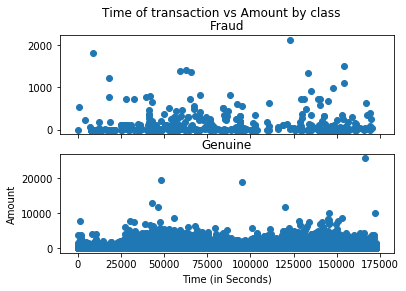

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(genuine.Time, genuine.Amount)
ax2.set_title('Genuine')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [12]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Split the dataset into 70% training data and 30% testing data.

In [13]:
train, test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)

# Creating input features and output label for train and test set
X_train = train.drop('Class', axis=1)
y_train = train['Class']

X_test = test.drop('Class', axis=1)
y_test = test['Class']

## Using Logistic Regression

In [14]:
# Importing Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(penalty='l2')

# training the regression model
logreg.fit(X_train, y_train)

/home/tarun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

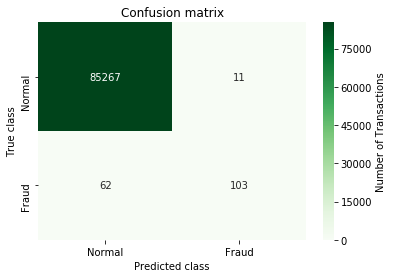

In [15]:
# predicting for test set using the trained Logistic Regression model
y_pred = logreg.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions'});
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Using Random Forests

In [13]:
from sklearn.ensemble import RandomForestClassifier

randForest = RandomForestClassifier(n_estimators=50, random_state=0)

# training the RandomForestClassifier
randForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

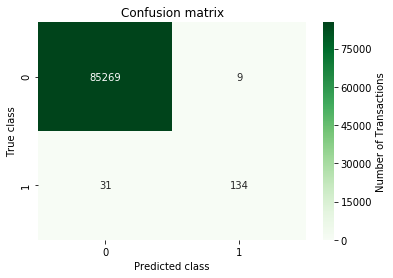

In [14]:
# predicting labels for testing set
y_pred = randForest.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions'})
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Dividing data into 4 batches

In [17]:
import random

# utility method to devide the data to create multiple batches. it divided the dataToSplit equally to each batch
# and adds the constData to each batch
def createBatches(dataToSplit, constData, batch):
    # based on number of batches calculate the size of each batch
    batchSize = int(dataToSplit.shape[0] / batch)
    
    # distribution batch numbers for batchsize number of elements each
    dataToSplit = dataToSplit.loc[random.sample(list(dataToSplit.index), batch * batchSize)]
    batch_no_array = np.array([])
    
    for itr in range(1, batch + 1):
        batch_no_array = np.append(batch_no_array, [itr] * batchSize)

    # shuffling the batch numbers so that data is randomly distributed in the batches
    np.random.shuffle(batch_no_array)
    dataToSplit.loc[:, 'batch'] = batch_no_array

    batches = []
    
    # creating batches based on the batch numbers
    for itr in range(1, batch + 1):
        newBatch = pd.concat([dataToSplit[dataToSplit['batch'] == itr], constData], sort=False)
        newBatch.drop(['batch'], axis=1, inplace=True)
        batches.append(newBatch)

    return batches

# Utility method to get predictions from multiple classifiers
def getCombinedPrediction(X_test, clfs):
    # creating the prediction variable with all 0 entries and adding the prediction of each classifier
    y_pred = [0]*X_test.shape[0]
    for clf in clfs:
        y_pred += clf.predict(X_test)

    # if atleast 2 classifiers predict transaction as fraud then label it as fraud
    y_pred = (y_pred >= 2).astype(int)
    return y_pred


In [18]:
# Utility method for undersampling the data
def preprocessunEqualDistribution(data, sampling_ratio):
    X = data.loc[:, data.columns != 'Class']
    y = data.loc[:, data.columns == 'Class']

    number_records_fraud = len(data[data['Class'] == 1])
    # getting the index of fraud transactions
    fraud_indices = np.array(data[data['Class'] == 1].index)
    # getting the index of genuine transactions
    normal_indices = data[data['Class'] == 0].index
    
    # randomizing the indexes considering the required sampling ratio
    random_normal_indices = np.random.choice(normal_indices,
                                             int((number_records_fraud * sampling_ratio) / (10 - sampling_ratio)),
                                             replace=False)

    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

    under_sample_data = data.loc[under_sample_indices, :]

    X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
    y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

    return X_undersample, y_undersample

#### Creating 4 batches

In [19]:
# creating 4 batches to train 
batches = createBatches(train[train.Class == 0], train[train.Class == 1], 4)

#### Training 4 Random Forests with each batch

In [18]:
clfs = []

for batch in batches:
    X_train = batch.drop('Class', axis=1)
    y_train = batch['Class']

    # Creating a RandomForestClassifier for each batch and saving it to clfs list
    classifier = RandomForestClassifier(n_estimators=50, random_state=0)
    classifier.fit(X_train, y_train.values.ravel())
    clfs.append(classifier)

#### Prediction for test set using 4 trained Random Forests

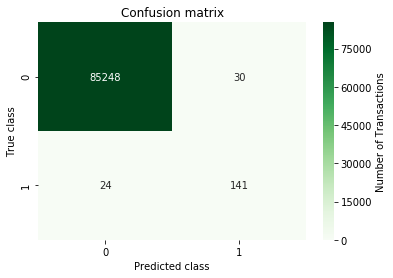

In [19]:
# getting the predicted labels using 4 trained classifiers
y_pred = getCombinedPrediction(X_test, clfs)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions'})
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### Training 4 Random Forests with each batch with 90:10 sampling

In [20]:
clfs = []

for batch in batches:
    # creating X and y set with 90:10 sampling
    X_train, y_train = preprocessunEqualDistribution(batch , 9)
    
    # training the classifiers and saving into clfs
    classifier = RandomForestClassifier(n_estimators=50, random_state=0)
    classifier.fit(X_train, y_train.values.ravel())
    clfs.append(classifier)

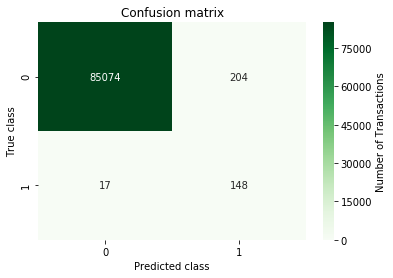

In [21]:
# predicting labels
y_pred = getCombinedPrediction(X_test, clfs)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions'})
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### Training 4 Random Forests with each batch with 80:20 sampling

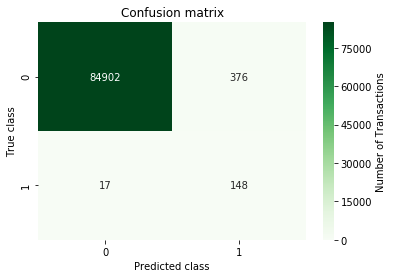

In [22]:
clfs = []

for batch in batches:
    # creating X and y set with 80:10 sampling
    X_train, y_train = preprocessunEqualDistribution(batch , 8)

    classifier = RandomForestClassifier(n_estimators=50, random_state=0)
    classifier.fit(X_train, y_train.values.ravel())
    clfs.append(classifier)

# predicting labels
y_pred = getCombinedPrediction(X_test, clfs)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions'})
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Using Autoencoders

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [23]:
# spliting data into train test set with 80:20 ratio
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

# creating input features and output labels for train set
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values


Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:


In [21]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [23]:
# defining the structure of autoencoder

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

print(autoencoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [26]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history


Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 15s 64us/step - loss: 0.8244 - acc: 0.5896 - val_loss: 0.7942 - val_acc: 0.6520
Epoch 2/100
227468/227468 [==============================] - 13s 57us/step - loss: 0.7489 - acc: 0.6590 - val_loss: 0.7760 - val_acc: 0.6638
Epoch 3/100
227468/227468 [==============================] - 13s 58us/step - loss: 0.7384 - acc: 0.6697 - val_loss: 0.7702 - val_acc: 0.6675
Epoch 4/100
227468/227468 [==============================] - 13s 58us/step - loss: 0.7332 - acc: 0.6731 - val_loss: 0.7661 - val_acc: 0.6773
Epoch 5/100
227468/227468 [==============================] - 13s 57us/step - loss: 0.7305 - acc: 0.6750 - val_loss: 0.7635 - val_acc: 0.6789
Epoch 6/100
227468/227468 [==============================] - 13s 57us/step - loss: 0.7286 - acc: 0.6748 - val_loss: 0.7675 - val_acc: 0.6713
Epoch 7/100
227468/227468 [==============================] - 13s 58us/step - loss: 0.7276 - acc: 0.6748

In [27]:
autoencoder = load_model('model.h5')


## Evaluation

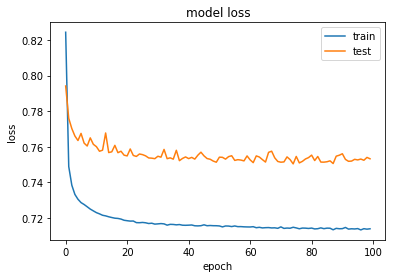

In [28]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [29]:
predictions = autoencoder.predict(X_test)

In [30]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [31]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.741389,0.002019
std,3.633362,0.044887
min,0.047110,0.000000
25%,0.242355,0.000000
50%,0.396429,0.000000
75%,0.633702,0.000000
max,409.560283,1.000000


### Reconstruction error without fraud

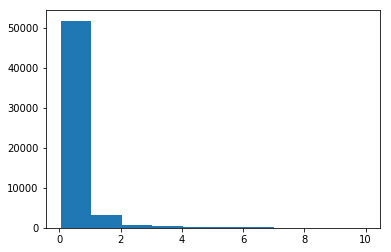

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)



### Reconstruction Error with fraud

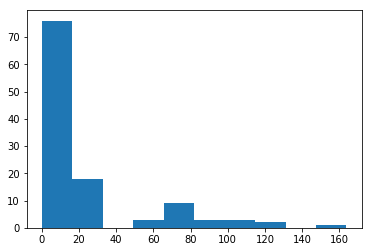

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [34]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


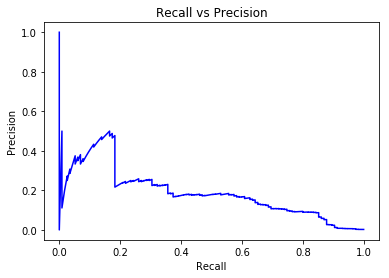

In [35]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

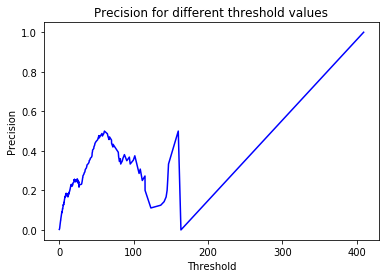

In [36]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

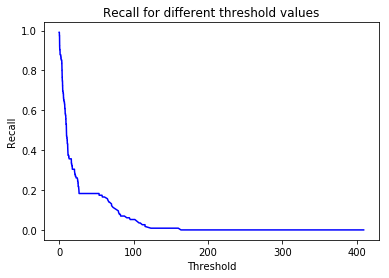

In [40]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()



Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:


In [50]:
threshold = 4

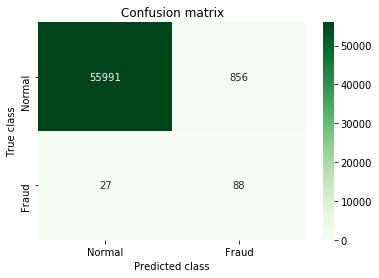

In [51]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, cmap="Greens", fmt='g');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()